## UCE

### Run model

In [6]:
%%bash

python eval_single_anndata.py \
	--adata_path "/data/nsiegel/projects/amp_data/phase2/objects/00_scgpt.h5ad" \
	--dir "/data/nsiegel/projects/amp_data/phase2/test_UCE/amp2"

[1] "/data/nsiegel/projects/amp_data/phase2/test_UCE/UCE"


### Read is result

In [34]:
%%R
# Update metadata and create seurat object
# metadata <- read.delim("metadata.csv", sep = ",")
# rownames(metadata) <- metadata$cell
# metadata <- metadata[-1]

adata <- anndataR::read_h5ad('../amp200_scgpt_uce_adata.h5ad')
# adata <- anndataR::read_h5ad('objects/01_scgpt.h5ad')
obj <- adata$to_Seurat()
# obj <- AddMetaData(obj, metadata = metadata)

adata

AnnData object with n_obs × n_vars = 24084 × 15639
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'sample', 'dataset', 'Site', 'Type', 'processing.batch', 'fine.type', 'broad.type', 'broad.group', 'blueprint.main', 'blueprint.fine', 'monaco.main', 'monaco.fine', 'Stim', 'Tissue_Type', 'Fine_Cell_Type', 'Broad_Cell_Type', 'Donor', 'n_genes'
    var: 'n_cells'
    obsm: 'X_uce'


In [31]:
%%R
# Update metadata and create seurat object
# metadata <- read.delim("metadata.csv", sep = ",")
# rownames(metadata) <- metadata$cell
# metadata <- metadata[-1]

adata <- anndataR::read_h5ad('10k_pbmcs_proc_uce_adata.h5ad')
# adata <- anndataR::read_h5ad('objects/01_scgpt.h5ad')
obj <- adata$to_Seurat()
# obj <- AddMetaData(obj, metadata = metadata)
adata

AnnData object with n_obs × n_vars = 11990 × 10809
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type', 'n_genes'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    obsm: 'X_uce', 'design', 'normalized_qc', 'qc_pc', 'raw_qc'


In [29]:
%%R

unique(adata$obs$cell_type)

[1] CD4 T cells       CD14+ Monocytes   CD8 T cells       B cells          
[5] Other             Dendritic Cells   FCGR3A+ Monocytes NK cells         
[9] Megakaryocytes   
9 Levels: B cells CD4 T cells CD8 T cells CD14+ Monocytes ... Other


### Compare with Seurat PBMC dataset

In [19]:
%%R
# Download example PBMC data
fn <- "https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
download.file(fn,destfile="tmp.tar.gz")
untar("tmp.tar.gz")
file.remove("tmp.tar.gz")
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

R[write to console]: trying URL 'https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz'



R[write to console]: Content type 'application/x-tar'
R[write to console]:  length 7621991 bytes (7.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts


## scGPT

### Intial Module and Package Setup

https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb

In [1]:
# Make sure scGPT is installed
import subprocess
import sys

# List of packages to check and install
packages = ["scgpt"]

for package_name in packages:
    try:
        __import__(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
# https://medium.com/@xuer.chen.human/a-step-by-step-guide-to-install-scgpt-79df167a64e3

/home/nsiegel/miniforge3/envs/scgpt/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/nsiegel/miniforge3/envs/scgpt/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/nsiegel/miniforge3/envs/scgpt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scgpt is already installed.


In [1]:
# Enable R magic
%load_ext rpy2.ipython

In [2]:
%%R

# Install R packages not on conda
if (!requireNamespace("anndataR", quietly = TRUE)) {
  if (!requireNamespace("devtools", quietly = TRUE)) install.packages("devtools")
  devtools::install_github("scverse/anndataR")
}

# Load R packages
suppressPackageStartupMessages({
    library(Seurat)
    library(celldex) # Automated annotation
    library(SingleR) # Automated annotation
    library(anndataR) # Convert adata to seurat
    library(gridExtra) # Plotting
    library(grid) # Plotting
    library(ggplot2)
    library(pheatmap) # Heatmap
    library(tidyr) # Heatmap
    library(dplyr) # Heatmap
})


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### Load and process data

In [54]:
%%R 
# Load and subset data

counts <- readRDS("data/2023-04-05_rawCounts_Sc_QCed.rds")
metadata <- readRDS("data/2023-04-05_metaData_Sc_QCed.rds")

cell_types <- c("Myeloid Cell")
obj <- CreateSeuratObject(counts = counts, meta.data = metadata, min.cells = 3, min.features = 300)
obj <- subset(obj, subset = broad.type == cell_types)
obj
save(obj, file=file.path('objects', '00_scgpt.rda'))

In [ ]:
%%R 
# Automated annotations

## Load annotation
monaco.ref <- celldex::MonacoImmuneData()
blueprint.ref <- celldex::BlueprintEncodeData()

## Blueprint annnotation
sce <- LayerData(obj)
blueprint.main <- SingleR(test = sce, assay.type.test = 1, ref = blueprint.ref, labels = blueprint.ref$label.main)
obj@meta.data$blueprint.main <- blueprint.main$pruned.labels

sce <- LayerData(obj)
blueprint.fine <- SingleR(test = sce, assay.type.test = 1, ref = blueprint.ref, labels = blueprint.ref$label.fine)
obj@meta.data$blueprint.fine <- blueprint.fine$pruned.labels

## Monaco annontation
sce <- LayerData(obj)
monaco.main <- SingleR(test = sce, assay.type.test = 1, ref = monaco.ref, labels = monaco.ref$label.main)
obj@meta.data$monaco.main <- monaco.main$pruned.labels

sce <- LayerData(obj)
monaco.fine <- SingleR(test = sce, assay.type.test = 1, ref = monaco.ref, labels = monaco.ref$label.fine)
obj@meta.data$monaco.fine <- monaco.fine$pruned.labels
save(obj, file=file.path('objects', '01_scgpt.rda'))

In [18]:
%%R 
# Update metadata

obj@meta.data$Stim <- obj@meta.data$Type
obj@meta.data$Tissue_Type <- obj@meta.data$broad.group
obj@meta.data$Fine_Cell_Type <- obj@meta.data$fine.type
obj@meta.data$Broad_Cell_Type <- obj@meta.data$broad.type
obj@meta.data$Donor <- gsub("AMPSLEkid_cells", "Donor",  obj@meta.data$sample)
save(obj, file=file.path('objects', '02_scgpt.rda'))

In [61]:
%%R -o counts_df -o metadata
# Save expression data

counts <- GetAssayData(obj, assay = "RNA")
counts_df <- as.data.frame(as.matrix(counts))
metadata <- obj@meta.data

In [ ]:
# Load the expression data and metadata
import pandas as pd
import scanpy as sc

adata = sc.AnnData(
    X=counts_df.T,
    obs=metadata,
    var=pd.DataFrame(index=counts_df.index.tolist()))
    
adata.write_h5ad("objects/00_scgpt.h5ad")

### Embedding for all human cells

In [ ]:
# Embedding modules

import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import sklearn
import warnings
import torch
import scanpy as sc
import scgpt as scg

# Override torch.load to handle CPU loading when CUDA is not available
if not torch.cuda.is_available():
    original_torch_load = torch.load
    def cpu_torch_load(*args, **kwargs):
        return original_torch_load(*args, map_location='cpu', **kwargs)
    torch.load = cpu_torch_load

In [ ]:
# All human

model_dir = Path("scgpt_models/human_whole")
# adata = sc.read_h5ad("objects/00_scgpt.h5ad")
cell_type_key = adata.obs.columns.tolist()
gene_col = "index"

# Run on Screen
ref_embed_adata = scg.tasks.embed_data(
    adata_or_file=adata,
    model_dir=model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key, 
    batch_size=64,
    return_new_adata=True,
)

# Create cell index
import faiss
from build_atlas_index_faiss import load_index, vote

use_gpu = False  # Force CPU usage
index, meta_labels = load_index(
    index_dir="CellXGene_faiss_index",
    use_config_file=False,
    use_gpu=use_gpu,
)

# Calculate distances
k = 50
distances, idx = index.search(ref_embed_adata.X, k)

# Generate prediction label
from tqdm import tqdm

predict_labels = meta_labels[idx]
voting = []
for preds in tqdm(predict_labels):
    voting.append(vote(preds, return_prob=False)[0])
voting = np.array(voting)

# Append new annotations
adata.obs['All_scGPT_Cell_Types'] = voting
adata.write_h5ad("objects/01_scgpt.h5ad")

In [ ]:
# All kidney cells

model_dir = Path("scgpt_models/human_kidney")
# adata = sc.read_h5ad("objects/00_scgpt.h5ad")
cell_type_key = adata.obs.columns.tolist()
gene_col = "index"

# Run on Screen
ref_embed_adata = scg.tasks.embed_data(
    adata_or_file=adata,
    model_dir=model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key, 
    batch_size=64,
    return_new_adata=True,
)

# Create cell index
import faiss
from build_atlas_index_faiss import load_index, vote

use_gpu = False  # Force CPU usage
index, meta_labels = load_index(
    index_dir="CellXGene_faiss_index",
    use_config_file=False,
    use_gpu=use_gpu,
)

# Calculate distances
k = 50
distances, idx = index.search(ref_embed_adata.X, k)

# Generate prediction label
from tqdm import tqdm

predict_labels = meta_labels[idx]
voting = []
for preds in tqdm(predict_labels):
    voting.append(vote(preds, return_prob=False)[0])
voting = np.array(voting)

# Append new annotations
adata.obs['Kidney_scGPT_Cell_Types'] = voting
adata.write_h5ad("objects/01_scgpt.h5ad")

In [77]:
# Export updated metadata
metadata_df = adata.obs
metadata_df.to_csv('metadata.csv')

In [3]:
%%R 
# Update metadata and create seurat object
metadata <- read.delim("metadata.csv", sep = ",")
rownames(metadata) <- metadata$cell
metadata <- metadata[-1]

adata <- anndataR::read_h5ad('objects/01_scgpt.h5ad')
obj <- adata$to_Seurat()
obj <- AddMetaData(obj, metadata = metadata)
save(obj, file = 'objects/03_scgpt.rda')

In [7]:
%%R
# Normalize and process data
options(future.globals.maxSize = 2000 * 1024^2)
obj <- SCTransform(obj, ncells = 3000,  variable.features.n = 2000, vst.flavor="v2", method = 'glmGamPoi',
            conserve.memory = FALSE, verbose = TRUE)

obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, dims = 1:20)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:20)
obj <- FindClusters(obj, resolution = 0.5)
save(obj, file = 'objects/04_scgpt.rda')

R[write to console]: Running SCTransform on assay: RNA

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 24045 by 24084

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 3000 cells

R[write to console]: Found 355 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 24045 genes

R[write to console]: Computing corrected count matrix for 24045 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.973412 mins

R[write to console]: Determine variable features

R[write to console]: Centering data matrix

  |          

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 24084
Number of edges: 787792

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.8937
Number of communities: 15
Elapsed time: 4 seconds


In [10]:
%%R

load(file = 'objects/04_scgpt.rda')

## Replace empty cell types with BA
obj@meta.data$monaco.main[obj@meta.data$monaco.main == ""] <- "undertermined"
obj@meta.data$blueprint.main[obj@meta.data$blueprint.main == ""] <- "undertermined"
obj@meta.data$monaco.fine[obj@meta.data$monaco.fine == ""] <- "undertermined"
obj@meta.data$blueprint.fine[obj@meta.data$blueprint.fine == ""] <- "undertermined"

# # Mapping of common cell types to standardized names
# cell_type_mapping <- list(
#   "Macrophages" = "macrophage",
#   "Macrophage" = "macrophage",
#   "mac" = "macrophage",
#   "Monocytes" = "monocyte",
#   "monocytes" = "monocyte",
#   "CD14-low, CD16-positive monocyte" = "monocyte",
#   "CD14-positive monocyte" = "monocyte",
#   "classical monocyte" = "monocyte",
#   "non-classical monocyte" = "monocyte",
#   "intermediate monocyte" = "monocyte",
#   "CD14+ CCR2+ Mono" = "monocyte",
#   "CD16+ CX3CR1+ Mono" = "monocyte",
#   "CD14+ CD16+ Mono" = "monocyte",
#   "promonocyte" = "monocyte",
#   "melanocyte" = "melanocyte",
#   "endothelial cell" = "endothelial cell",
#   "lamp5 GABAergic cortical interneuron" = "lamp5 GABAergic interneuron",
#   "mast cell" = "mast cell",
#   "MHC2lo" = "dendritic cell",
#   "cDC1" = "dendritic cell",
#   "DC" = "dendritic cell",
#   "CCR7+ LAMP3+ cDC2" = "dendritic cell",
#   "pDC" = "dendritic cell",
#   "conventional dendritic cell" = "dendritic cell",
#   "plasmacytoid dendritic cell" = "dendritic cell",
#   "neutrophil" = "neutrophil",
#   "lymphocyte" = "lymphocyte",
#   "T cell" = "T-cell",
#   "T cells" = "T-cell",
#   "CD4+ T cells" = "T-cell",
#   "CD8+ T cells" = "T-cell",
#   "CD4+ T-cells" = "T-cell",
#   "CD8+ T-cells" = "T-cell",
#   "B cell" = "B-cell",
#   "B cells" = "B-cell",
#   "B-cells" = "B-cell",
#   "alveolar macrophage" = "macrophage",
#   "basophil" = "basophil",
#   "glial cell" = "glial cell",
#   "progenitor cell" = "progenitor cell",
#   "hematopoietic stem cell" = "HSC",
#   "granulocyte" = "granulocyte",
#   "osteoclast" = "osteoclast",
#   "CD1c-positive myeloid dendritic cell" = "dendritic cell",
#   "dendritic cell, human" = "dendritic cell",
#   "hematopoietic precursor cell" = "hematopoietic cell",
#   "germinal center B cell" = "B-cell",
#   "plasmablast" = "B-cell",
#   "granulocyte monocyte progenitor cell" = "progenitor cell",
#   "fibroblast of mammary gland" = "fibroblast",
#   "plasmacytoid dendritic cell, human" = "pDC",
#   "hematopoietic cell" = "hematopoietic cell",
#   "innate lymphoid cell" = "innate lymphoid cell",
#   "transit amplifying cell" = "transit amplifying cell",
#   "kidney collecting duct principal cell" = "kidney cell",
#   "naive thymus-derived CD4-positive, alpha-beta T cell" = "T-cell",
#   "Dendritic cells" = "dendritic cell",
#   "CD141-positive myeloid dendritic cell" = "dendritic cell",
#   "Basophils" = "basophil",
#   "Progenitors" = "progenitor cell",
#   "Neutrophils" = "neutrophil",
#   "CD4+ T cells" = "T-cell",
#   "NK cells" = "NK cell",
#   "12. SELENOP+ LYVE1hi Mac" = "macrophage",
#   "inflammatory macrophage" = "macrophage",
#   "0. CD16+ CX3CR1+ Mono" = "monocyte",
#   "17. MHC2hi cDC2" = "dendritic cell",
#   "2. CD14+ CCR2+ Mono" = "monocyte",
#   "19. cDC1" = "dendritic cell",
#   "16. APOC1lo C3hi Mac" = "macrophage",
#   "4. Mast Cell" = "mast cell",
#   "3. CD14+ CCL2+ Mono" = "monocyte",
#   "5. C1Qlo NUPR1hi Mac" = "macrophage",
#   "10. SELENOP+ LYVE1lo Mac" = "macrophage",
#   "20. pDC" = "dendritic cell",
#   "13. CCR7+ LAMP3+ cDC2" = "dendritic cell",
#   "11. C1Qhi GPNMBhi Mac" = "macrophage",
#   "18. CENPF+ MKI67+ Proliferating" = "proliferating cell",
#   "7. C1Qlo FABP5hi SPP1hi Mac" = "macrophage",
#   "1. CD14+ CD16+ Mono" = "monocyte",
#   "15. MHC2lo cDC2" = "dendritic cell",
#   "14. APOC1hi C3hi Mac" = "macrophage",
#   "9. C1Qhi FABP5hi SPP1hi Mac" = "macrophage",
#   "6. SELENOP+ TIMP1+ Mac" = "macrophage",
#   "8. SELENOP- TIMP1+ Mac" = "macrophage",
#   "myeloid leukocyte" = "myeloid cell",
#   "leukocyte" = "leukocyte",
#   "memory B cell" = "B-cell",
#   "elicited macrophage" = "macrophage",
#   "alternatively activated macrophage" = "macrophage",
#   "CD14-positive, CD16-positive monocyte" = "monocyte"
# )

In [11]:
%%R

cell_type_mapping <- list(
  "0. CD16+ CX3CR1+ Mono" = "monocyte",
  "1. CD14+ CD16+ Mono" = "monocyte",
  "10. SELENOP+ LYVE1lo Mac" = "macrophage",
  "11. C1Qhi GPNMBhi Mac" = "macrophage",
  "12. SELENOP+ LYVE1hi Mac" = "macrophage",
  "13. CCR7+ LAMP3+ cDC2" = "dendritic cell",
  "14. APOC1hi C3hi Mac" = "macrophage",
  "15. MHC2lo cDC2" = "dendritic cell",
  "16. APOC1lo C3hi Mac" = "macrophage",
  "17. MHC2hi cDC2" = "dendritic cell",
  "18. CENPF+ MKI67+ Proliferating" = "fibroblast",
  "19. cDC1" = "dendritic cell",
  "2. CD14+ CCR2+ Mono" = "monocyte",
  "20. pDC" = "dendritic cell",
  "3. CD14+ CCL2+ Mono" = "monocyte",
  "4. Mast Cell" = "mast cell",
  "5. C1Qlo NUPR1hi Mac" = "macrophage",
  "6. SELENOP+ TIMP1+ Mac" = "macrophage",
  "7. C1Qlo FABP5hi SPP1hi Mac" = "macrophage",
  "8. SELENOP- TIMP1+ Mac" = "macrophage",
  "9. C1Qhi FABP5hi SPP1hi Mac" = "macrophage",
  "B cells" = "B-cell",
  "Basophils" = "basophil",
  "CD4+ T cells" = "T-cell",
  "CD8+ T cells" = "T-cell",
  "Dendritic cells" = "dendritic cell",
  "Monocytes" = "monocyte",
  "NK cells" = "NK cell",
  "Neutrophils" = "neutrophil",
  # "Progenitors" = "",
  "T cells" = "T-cell",
  # "undertermined" = "",
  # "Adipocytes" = "",
  "B-cells" = "B-cell",
  "CD4+ T-cells" = "T-cell",
  "CD8+ T-cells" = "T-cell",
  "DC" = "dendritic cell",
  "Eosinophils" = "eosinophil",
  # "Erythrocytes" = "",
  # "HSC" = "",
  "Macrophages" = "macrophage",
  # "Mesangial cells" = "",
  # "" = "",
  "Classical monocytes" = "monocyte",
  "Exhausted B cells" = "B-cell",
  "Intermediate monocytes" = "monocyte",
  "Low-density basophils" = "basophil",
  "Low-density neutrophils" = "neutrophil",
  "MAIT cells" = "mait cell",
  "Myeloid dendritic cells" = "dendritic cell",
  "Naive B cells" = "B-cell",
  "Naive CD4 T cells" = "T-cell",
  "Natural killer cells" = "NK cell",
  "Non classical monocytes" = "monocyte",
  "Non-switched memory B cells" = "B-cell",
  "Plasmacytoid dendritic cells" = "dendritic cell",
  "Progenitor cells" = "B-cell",
  "Switched memory B cells" = "B-cell",
  "T regulatory cells" = "T-cell",
  "CD4+ Tcm" = "T-cell",
  "CD8+ Tcm" = "T-cell",
  "CD8+ Tem" = "T-cell",
  # "CLP" = "",
  # "CMP" = "",
  "Class-switched memory B-cells" = "B-cell",
  # "GMP" = "",
  "MEP" = "megakaryocyte",
  # "MPP" = "",
  "Macrophages M1" = "macrophage",
  "Macrophages M2" = "macrophage",
  "Megakaryocytes" = "megakaryocyte",
  "Memory B-cells" = "B-cell",
  "Plasma cells" = "B-cell",
  "Tregs" = "T-cell",
  "naive B-cells" = "B-cell",
  "L2/3-6 intratelencephalic projecting glutamatergic cortical neuron" = "neuron",
  # "endothelial cell" = "",
  "lamp5 GABAergic cortical interneuron" = "neuron",
  "mast cell" = "mast cell",
  # "melanocyte" = "",
  "near-projecting glutamatergic cortical neuron" = "neuron",
  # "platelet" = "",
  "B cell" = "B-cell",
  "CD14-low, CD16-positive monocyte" = "monocyte",
  "CD14-positive monocyte" = "monocyte",
  "CD14-positive, CD16-positive monocyte" = "monocyte",
  "CD141-positive myeloid dendritic cell" = "dendritic cell",
  "CD1c-positive myeloid dendritic cell" = "dendritic cell",
  "CD4-positive, alpha-beta T cell" = "T-cell",
  "Langerhans cell" = "dendritic cell",
  "T cell" = "T-cell",
  "alternatively activated macrophage" = "macrophage",
  "alveolar macrophage" = "macrophage",
  # "animal cell" = "",
  # "basophil" = "",
  # "brush cell" = "",
  "classical monocyte" = "monocyte",
  "conventional dendritic cell" = "dendritic cell",
  "dendritic cell" = "dendritic cell",
  "dendritic cell, human" = "dendritic cell",
  "elicited macrophage" = "macrophage",
  "epithelial cell of proximal tubule" = "",
  "fibroblast of mammary gland" = "fibroblast",
  "germinal center B cell" = "B-cell",
  # "glial cell" = "",
  "granulocyte" = "",
  "granulocyte monocyte progenitor cell" = "monocyte",
  # "group 3 innate lymphoid cell" = "",
  "hematopoietic multipotent progenitor cell" = "HSC",
  "hematopoietic precursor cell" = "HSC",
  "inflammatory macrophage" = "macrophage",
  "intermediate monocyte" = "monocyte",
  # "kidney collecting duct intercalated cell" = "",
  # "kidney loop of Henle thin descending limb epithelial cell" = "",
  # "leukocyte" = "",
  "lung macrophage" = "macrophage",
  # "lymphocyte" = "",
  "macrophage" = "macrophage",
  "memory B cell" = "B-cell",
  # "microglial cell" = "",
  # "monocyte" = "monocyte",
  # "myeloid cell" = "",
  # "myeloid leukocyte" = "",
  # "native cell" = "",
  # "neutrophil" = "",
  "non-classical monocyte" = "monocyte",
  # "osteoclast" = "",
  "plasmablast" = "B-cell",
  "plasmacytoid dendritic cell" = "dendritic cell",
  "plasmacytoid dendritic cell, human" = "dendritic cell",
  # "progenitor cell" = "",
  "promonocyte" = "monocyte"
)

In [12]:
%%R
# Generate plot

p1 <- DimPlot(obj, reduction = "umap", group.by = "Fine_Cell_Type", label = FALSE) + 
  ggtitle("Custom Annotation")  +
  theme(legend.position = "bottom", legend.direction = "horizontal", legend.key.size = unit(0.1, "cm"))
  ggsave("figures/Fine_Cell_Type.png", plot = p1, width = 14, height = 10,limitsize = FALSE)

p2 <- DimPlot(obj, reduction = "umap", group.by = "monaco.main", label = FALSE) + 
  ggtitle("Monaco Annotation")
  ggsave("figures/monaco_main.png", plot = p2, width = 14, height = 10,limitsize = FALSE)

p3 <- DimPlot(obj, reduction = "umap", group.by = "blueprint.main", label = FALSE) + 
  ggtitle("Blueprint Annotation")
  ggsave("figures/blueprint_main.png", plot = p3, width = 14, height = 10,limitsize = FALSE)

p4 <- DimPlot(obj, reduction = "umap", group.by = "monaco.fine", label = FALSE) + 
  ggtitle("Monaco Annotation")
  ggsave("figures/monaco_fine.png", plot = p4, width = 14, height = 10,limitsize = FALSE)

p5 <- DimPlot(obj, reduction = "umap", group.by = "blueprint.fine", label = FALSE) + 
  ggtitle("Blueprint Annotation")
  ggsave("figures/blueprint_fine.png", plot = p5, width = 14, height = 10,limitsize = FALSE)

p6 <- DimPlot(obj, reduction = "umap", group.by = "Kidney_scGPT_Cell_Types", label = FALSE) + 
  ggtitle("scGPT Kidney")
  ggsave("figures/Kidney_scGPT_Cell_Types.png", plot = p6, width = 14, height = 10,limitsize = FALSE)

p7 <- DimPlot(obj, reduction = "umap", group.by = "All_scGPT_Cell_Types", label = FALSE) + 
  ggtitle("scGPT All") +
  theme(legend.position = "bottom", legend.direction = "vertical", legend.key.size = unit(0.1, "cm"))
ggsave("figures/All_scGPT_Cell_Types.png", plot = p7, width = 14, height = 10,limitsize = FALSE)

In [13]:
%%R

# Create a long format data frame for visualization
annotation_columns <- c("Fine_Cell_Type", "monaco.main", "blueprint.main", "monaco.fine", "blueprint.fine",
    "Kidney_scGPT_Cell_Types", "All_scGPT_Cell_Types") 

long_data <- lapply(annotation_columns, function(col) {
  obj@meta.data %>%
    group_by(!!sym(col)) %>%
    summarise(CellCount = n()) %>%
    mutate(Annotation = col) %>%
    rename(CellType = !!sym(col))
}) %>% 
bind_rows() 

In [14]:
%%R

heatmap_data <- long_data %>%
  pivot_wider(names_from = Annotation, values_from = CellCount, values_fill = list(CellCount = 0)) %>%
  drop_na() 

In [16]:
%%R

heatmap_data$CellType

  [1] "0. CD16+ CX3CR1+ Mono"                                             
  [2] "1. CD14+ CD16+ Mono"                                               
  [3] "10. SELENOP+ LYVE1lo Mac"                                          
  [4] "11. C1Qhi GPNMBhi Mac"                                             
  [5] "12. SELENOP+ LYVE1hi Mac"                                          
  [6] "13. CCR7+ LAMP3+ cDC2"                                             
  [7] "14. APOC1hi C3hi Mac"                                              
  [8] "15. MHC2lo cDC2"                                                   
  [9] "16. APOC1lo C3hi Mac"                                              
 [10] "17. MHC2hi cDC2"                                                   
 [11] "18. CENPF+ MKI67+ Proliferating"                                   
 [12] "19. cDC1"                                                          
 [13] "2. CD14+ CCR2+ Mono"                                               
 [14] "20. pDC"          

In [17]:
%%R

# Summarizing the data by CellType, including summing Fine_Cell_Type
cell_type_mapping_vector <- unlist(cell_type_mapping)
heatmap_data <- heatmap_data %>%
  mutate(CellType = recode(CellType, !!!cell_type_mapping_vector)) %>%
  group_by(CellType) %>%
  summarise(
    Fine_Cell_Type = sum(Fine_Cell_Type, na.rm = TRUE),  
    monaco.main = sum(monaco.main, na.rm = TRUE), 
    blueprint.main = sum(blueprint.main, na.rm = TRUE), 
    monaco.fine = sum(monaco.fine, na.rm = TRUE), 
    blueprint.fine = sum(blueprint.fine, na.rm = TRUE), 
    Kidney_scGPT_Cell_Types = sum(Kidney_scGPT_Cell_Types, na.rm = TRUE),
    All_scGPT_Cell_Types = sum(All_scGPT_Cell_Types, na.rm = TRUE),
    .groups = 'drop'  # Drop grouping afterwards
  )

In [18]:
%%R
# Reshape to wide format

rownames(heatmap_data) <- heatmap_data$CellType
heatmap_matrix <- as.matrix(heatmap_data[, -1])  # Exclude CellType column

rownames(heatmap_matrix) <- heatmap_data$CellType

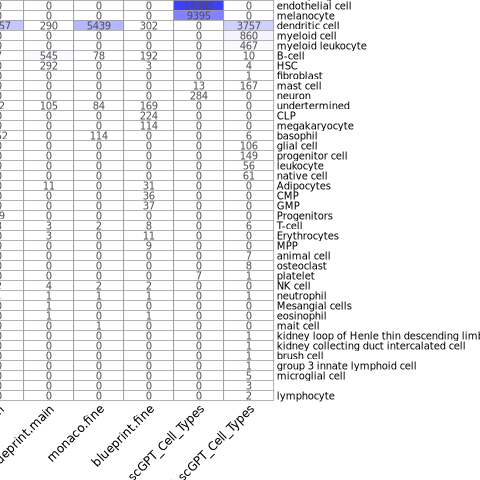

In [26]:
%%R

ph <- pheatmap(heatmap_matrix, 
         cluster_rows = TRUE, 
         gaps_row = 5,
         cluster_cols = FALSE, 
         display_numbers = TRUE, 
         fontsize_number = 10,
         number_format = "%.0f",
         fontsize_col = 12, 
         cellwidth = 50,  
         cellheight = 10,  
         angle_col = 45,    
         cutree_rows = 2,
         main = "Myeloid Cell Type Counts by Annotation Method",
         color = colorRampPalette(c("white", "blue"))(50))
ggsave("figures/heatmap.png", plot = ph, width = 12, height = 8)

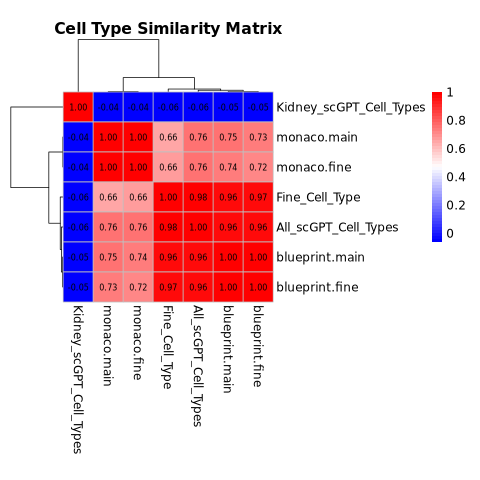

In [20]:
%%R

# Plot the similarity matrix with improved readability
similarity_matrix <- cor(heatmap_matrix)
p <-pheatmap(similarity_matrix, 
         main = "Cell Type Similarity Matrix",
         cluster_rows = TRUE, 
         cluster_cols = TRUE,
         fontsize = 12,                    # Increase font size for labels
         fontsize_number = 8,             # Increase font size for numbers
         color = colorRampPalette(c("blue", "white", "red"))(50),
         display_numbers = TRUE,            # Show numbers in cells
         number_color = "black",            # Change number color for contrast
         cellwidth = 30,                    # Adjust cell width
         cellheight = 30,                   # Adjust cell height
         border_color = "grey")             # Add borders for clarity

ggsave("figures/similarity_matrix.png", plot = p, width = 10, height = 8)

## Celltypist

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached igraph-0.11.6-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 37.8 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached igraph-0.11.6-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)


In [2]:
!pip install celltypist
!pip uninstall scanpy matplotlib -y
!pip install scanpy matplotlib

import celltypist
from celltypist import models

  Using cached celltypist-1.6.3-py3-none-any.whl.metadata (43 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached igraph-0.11.6-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached celltypist-1.6.3-py3-none-any.whl (7.3 MB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached igraph-0.11.6-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Using cached texttable-1.7.0-py2.py3-none-any.w

In [3]:
models.download_models(model = ['Immune_All_Low.pkl', 'Immune_All_High.pkl'], force_update = True)

Found existing installation: scanpy 1.7.2
Uninstalling scanpy-1.7.2:
  Successfully uninstalled scanpy-1.7.2
Found existing installation: matplotlib 3.9.2
Uninstalling matplotlib-3.9.2:
  Successfully uninstalled matplotlib-3.9.2
